# Binary Classification on Health Data - KNN

In [4]:
import pandas as pd
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('./health_data.csv').values
print(type(data), data.shape)
print("class distribution",np.bincount(data[:,-1]))

<class 'numpy.ndarray'> (700, 4)
class distribution [400 300]


In [6]:
# np.random.shuffle(data)

# train_data=data[0:490,:]
# test_data=data[490:700,:]
train_data=np.load('train_data_KNNParzen.npy')
test_data=np.load('test_data_KNNParzen.npy')

Cross_Validation_data=np.array_split(train_data,5)
print(len(Cross_Validation_data))

X_TEST,y_TEST = test_data[:,:-1],test_data[:,-1:]
print(X_TEST.shape, y_TEST.shape)

5
(490, 3) (490, 1)


In [7]:
print(train_data.shape, Cross_Validation_data[0].shape)
print('train data size = 398\nval data size = 98\nTEST data size = 210')

(490, 4) (98, 4)
train data size = 398
val data size = 98
TEST data size = 210


#### Classification Performance Metrics

In [8]:
#assuming y_pred, y_true shape is (n,)
#assuming class 1 is positive, and other is negative
#assuming multi-class such that ypred,ytrue has values in 0,1,2,..,label-1

def classification_performance_metrics(y_pred, y_true):
    n=y_true.shape
    
    tp_indices = y_pred==y_true
    tp = y_true[tp_indices]
    
    true_y_per_class = np.bincount(y_true)
    labels = true_y_per_class.shape[0]
    
    tp_per_class = np.zeros((labels,))
    tp_per_class[:np.bincount(tp).shape[0]] = np.bincount(tp)
    predicted_y_per_class = np.zeros((labels,))
    predicted_y_per_class[:np.bincount(y_pred).shape[0]] = np.bincount(y_pred)
    
    
    acc = tp_per_class.sum()/n
    
    #precision, recall, F1 for each class
    for i in range(tp_per_class.shape[0]):
        TP = tp_per_class[i]
        TN = tp_per_class.sum() - TP
        FP = predicted_y_per_class[i] - TP
        FN = true_y_per_class[i] - TP
        
        precision = TP/(TP+FP) if TP+FP!=0 else 0
        recall = TP/(TP+FN) if TP+FN!=0 else 0
        F1 = 2*TP/(2*TP+FP+FN) if TP+FP+FN!=0 else 0
        FPR = FP/(FP+TN) if FP+TN!=0 else 0

#         print("class{}".format(i),precision,recall,F1)
    
    performance={}
    performance['acc']=acc
    performance['precision']=precision
    performance['TPR']=recall
    performance['recall']=recall
    performance['F1']=F1
    performance['FPR']=FPR
    return performance

# K-Nearest Neighbour

In [9]:
'''
input - 
train_data (n,d+1) - last col is y
X_test (n,d)
k = no. of neighbours
threshold 
metric - 0,1,2 norm : distance/metric between two vectors | 0 means infinite norm

output-
y_pred (n,)
'''
def Predict_using_KNN(train_data, X_test, k, threshold, metric):
    X_train = train_data[:,:-1]
    y_train = train_data[:,-1:]
    y_pred_test = np.zeros((X_test.shape[0],),dtype='uint8')
    for i in range(len(X_test)):
        x = X_test[i].reshape(1,-1)
        metrics = np.absolute(X_train-x)
        if metric==0:
            metrics = metrics.max(axis=1)
        elif metric==1:
            metrics = metrics.sum(axis=1)
        else: # metric=2
            metrics = np.sqrt(np.square(metrics).sum(axis=1))
        
        metrics_mapped_to_labels = np.column_stack((metrics,y_train))
        metrics_mapped_to_labels = metrics_mapped_to_labels[metrics_mapped_to_labels[:,0].argsort()]
        
        #now estimate the posteriors for both the classes (basically here Q_i = k_i/k is computed, k is removed)
        Q_0, Q_1 = 0, 0
        for j in range(k):
            if(metrics_mapped_to_labels[j,1]==0):
                Q_0+=1
            else:
                Q_1+=1
        if(Q_1>=threshold*Q_0):
            y_pred_test[i]=1
    return y_pred_test

In [10]:
#cross validate
def cross_validate(Cross_Validation_data, k, threshold, metric):
    TPR_CV, FPR_CV, test_acc_CV = [],[],[]
    for i,validation_data in enumerate(Cross_Validation_data):
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        train = remaining_data_for_training
        X_test, y_test = validation_data[:,:-1], validation_data[:,-1]
        y_pred_test = Predict_using_KNN(train, X_test, k=k, threshold=threshold, metric=metric)

        performance = classification_performance_metrics(y_pred_test, y_test)

        TPR_CV.append(performance['TPR'])
        FPR_CV.append(performance['FPR'])
        test_acc_CV.append(performance['acc'])

    test_acc, TPR, FPR = sum(test_acc_CV)/5 ,np.array(TPR_CV).sum(axis=0)/5, np.array(FPR_CV).sum(axis=0)/5
    return test_acc[0], TPR, FPR

## what all we need to experiment
1. decide the value of k using bias variance decomposition
2. decide the metric using bias variance decomposition
3. after having k and metric, get the ROC curve 
4. finally give the cross validation and TEST accuracy!

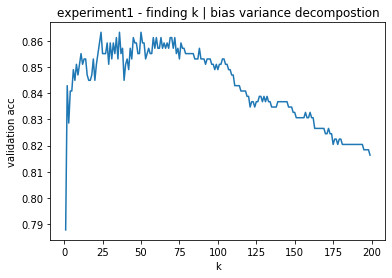

In [13]:
test_accs = []
ks=np.arange(1,200,1)
for k in ks:
    print('k=%u'%k,end='\r')
    _1, _2, _3 = cross_validate(Cross_Validation_data, k=k, threshold=1, metric=2)
    test_accs.append(_1)
plt.title('experiment1 - finding k | bias variance decompostion')
plt.plot(ks, test_accs)
plt.xlabel('k')
plt.ylabel('validation acc')
plt.show()

In [14]:
test_accs_KNN = test_accs

In [15]:
print("max val acc k =",ks[test_accs.index(max(test_accs))])

max val acc k = 24


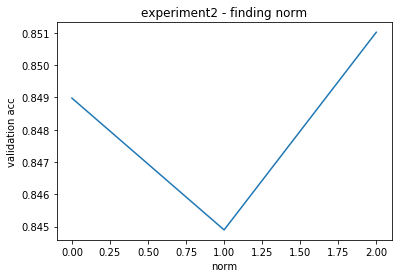

In [14]:
test_accs = []
norms=[0,1,2]
for norm in norms:
    print('norm=%u'%norm,end='\r')
    _1, _2, _3 = cross_validate(Cross_Validation_data, k=29, threshold=1, metric=norm)
    test_accs.append(_1)
plt.title('experiment2 - finding norm')
plt.plot(norms, test_accs)
plt.xlabel('norm')
plt.ylabel('validation acc')
plt.savefig('finding norm.png')
plt.show()

#### Thus L2 norm based distance is the best! | NOTE: 0 is the infinite norm

In [3]:
# plot the roc curve 
TPR_roc, FPR_roc = [], []
# thresholds = list(np.arange(0,5,.01))+list(np.arange(5,10,0.1))
thresholds=[0,.00001,0.001,0.01,.05,0.1,1,5,10,20,100]
for threshold in thresholds:
    print('threshold=%f'%threshold,end='\r')
    _1, _2, _3 = cross_validate(Cross_Validation_data, k=29, threshold=threshold, metric=2)
    TPR_roc.append(_2), FPR_roc.append(_3)
TPR_roc.reverse() 
FPR_roc.reverse()
plt.title('experiment3 - finding threshold | ROC Curve')
plt.plot(FPR_roc, TPR_roc,label='TPR vs FPR for class1',marker='.')
plt.plot(np.arange(0,1.1,.1),np.arange(0,1.1,.1),linestyle='dashed')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [18]:
FPR_KNN = FPR_roc
TPR_KNN = TPR_roc

#### Taking threshold = 1

In [19]:
# FINALLY, give cross validation accuracy and complete TEST accuracy
cross_val_acc, TPR, FPR = cross_validate(Cross_Validation_data, k=29, threshold=1, metric=2)
print("cross validation",cross_val_acc, TPR, FPR)

cross validation 0.8510204081632653 0.8221674365191696 0.12043257950945052


In [20]:
y_pred_TEST = Predict_using_KNN(train_data, X_TEST, k=29, threshold=1, metric=2)
performance = classification_performance_metrics(y_pred_TEST, y_TEST[:,0])
print(performance)

{'acc': array([0.86734694]), 'precision': 0.8585365853658536, 'TPR': 0.8301886792452831, 'recall': 0.8301886792452831, 'F1': 0.8441247002398081, 'FPR': 0.10431654676258993}


# Binary Classification on Health Data - Parzen Windows

In [21]:
'''
input - 
train_data (n,d+1) - last col is y
X_test (n,d)
h = window size => x belongs in hypercube (of vol h^d) centered at x0 if np.max(np.absolute(x-xo))<=h/2
threshold 

output-
y_pred (n,)
'''
def Predict_using_Parzen(train_data, X_test, h, threshold):
    X_train = train_data[:,:-1]
    y_train = train_data[:,-1]
    priors = np.bincount(y_train)/y_train.shape[0]
    
    y_pred_test = np.zeros((X_test.shape[0],),dtype='uint8')
    for i in range(len(X_test)):
        x = X_test[i].reshape(1,-1)
        window_fn = np.max(np.absolute(X_train-x),axis=1) <= (h/2)
        labels_inside_window = y_train[window_fn]
        
        class_conditional_densities = (labels_inside_window==0).sum(), (labels_inside_window==1).sum()
        
        #now estimate the posteriors for both the classes (basically here Q_i = p_i*f_i is computed; unnormalised)
        Q_1, Q_0 = priors[1]*class_conditional_densities[1], priors[0]*class_conditional_densities[0]
        if(Q_1>=threshold*Q_0):
            y_pred_test[i]=1

    return y_pred_test

In [22]:
#cross validate
def cross_validate(Cross_Validation_data, h, threshold):
    TPR_CV, FPR_CV, test_acc_CV = [],[],[]
    for i,validation_data in enumerate(Cross_Validation_data):
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        train = remaining_data_for_training
        X_test, y_test = validation_data[:,:-1], validation_data[:,-1]
        y_pred_test = Predict_using_Parzen(train, X_test, h=h, threshold=threshold)

        performance = classification_performance_metrics(y_pred_test, y_test)

        TPR_CV.append(performance['TPR'])
        FPR_CV.append(performance['FPR'])
        test_acc_CV.append(performance['acc'])

    test_acc, TPR, FPR = sum(test_acc_CV)/5 ,np.array(TPR_CV).sum(axis=0)/5, np.array(FPR_CV).sum(axis=0)/5
    return test_acc[0], TPR, FPR

In [1]:
test_accs = []
hs=np.arange(1,200,1)
for h in hs:
    print('h=%f'%h,end='\r')
    _1, _2, _3 = cross_validate(Cross_Validation_data, h=h, threshold=1)
    test_accs.append(_1)
plt.title('experiment1 - finding h | bias variance decompostion')
plt.plot(hs, test_accs)
plt.xlabel('h')
plt.ylabel('validation acc')
plt.show()

In [24]:
test_accs_Parzen = test_accs

In [25]:
print("max val acc h =",hs[test_accs.index(max(test_accs))])

max val acc h = 22


In [2]:
# plot the roc curve 
TPR_roc, FPR_roc = [], []
# thresholds = list(np.arange(0,5,.01))+list(np.arange(5,10,0.1))
thresholds=[0,.00001,0.001,0.01,.05,0.1,1,5,10,20,100]
for threshold in thresholds:
    print('threshold=%f'%threshold,end='\r')
    _1, _2, _3 = cross_validate(Cross_Validation_data, h=22, threshold=threshold)
    TPR_roc.append(_2), FPR_roc.append(_3)
TPR_roc.reverse() 
FPR_roc.reverse()
plt.title('experiment2 - finding threshold | ROC Curve')
plt.plot(FPR_roc,TPR_roc,label='TPR vs FPR for class1',marker='.')
plt.plot(np.arange(0,1.1,.1),np.arange(0,1.1,.1),linestyle='dashed')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [27]:
FPR_Parzen=FPR_roc
TPR_Parzen=TPR_roc

In [28]:
# FINALLY, give cross validation accuracy and complete TEST accuracy
cross_val_acc, TPR, FPR = cross_validate(Cross_Validation_data, h=22, threshold=1)
print("cross validation",cross_val_acc, TPR, FPR)

cross validation 0.8530612244897959 0.7811717849972022 0.08392280179754416


In [29]:
y_pred_TEST = Predict_using_Parzen(train_data, X_TEST, h=22, threshold=1)
performance = classification_performance_metrics(y_pred_TEST, y_TEST[:,0])
print(performance)

{'acc': array([0.8755102]), 'precision': 0.9171270718232044, 'TPR': 0.7830188679245284, 'recall': 0.7830188679245284, 'F1': 0.8447837150127226, 'FPR': 0.0539568345323741}


In [74]:
d=np.array([FPR_KNN,FPR_Parzen,TPR_KNN,TPR_Parzen])
np.save('Q1_KNNParzen_ROC.npy',d)

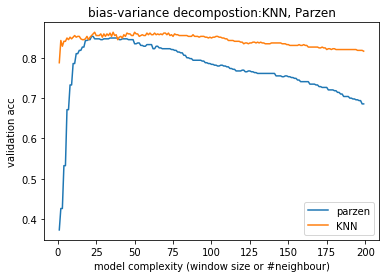

In [35]:
plt.title('bias-variance decompostion:KNN, Parzen')
x=np.arange(1,200,1)
plt.plot(x, test_accs_Parzen,label='parzen')
plt.plot(x, test_accs_KNN,label='KNN')
plt.xlabel('model complexity (window size or #neighbour)')
plt.ylabel('validation acc')
plt.legend()
plt.savefig('BiasVariance_KNNParzen.png')
plt.show()